In [1]:
# (For Colab only)
%tensorflow_version 2.x 
%matplotlib inline

In [2]:
import numpy as np
import os
import time
import scipy.io as sio
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import seaborn
import pandas as pd

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Constants

In [3]:
SEED = 42
IMAGES_SIZE = 224
IMAGES_DIR = 'jpg/'
ANNOTATIONS_FILE_PATH = 'imagelabels.mat'
SAVED_MODELS_DIR = 'models/'

BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Fetch and parse data

In [4]:
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

--2020-06-17 18:43:17--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  83.1MB/s    in 4.0s    

2020-06-17 18:43:21 (82.2 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [5]:
!wget 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'

--2020-06-17 18:43:22--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2020-06-17 18:43:22 (81.1 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [6]:
!tar xzf '102flowers.tgz'

# Utility classes

In [7]:
class DataParser: 
    IMAGE_FILES_NAME_PREFIX = 'image_'
    IMAGE_FILES_EXTENSION = '.jpg'

    def __init__(self, annotations_mat_file):
        self.annotations = self._load_annotations(annotations_mat_file)

    def get_image_label(self, image_file_name):
        image_number = self._get_image_number(image_file_name)
        return self.annotations[image_number]

    def _load_annotations(self, annotations_mat_file):
        annotations_mat = sio.loadmat(annotations_mat_file)
        return np.reshape(annotations_mat['labels'], -1)

    def _get_image_number(self, image_file_name):
        image_numer_str = image_file_name.replace(DataParser.IMAGE_FILES_NAME_PREFIX, '').replace(DataParser.IMAGE_FILES_EXTENSION, '')
        return int(image_numer_str.lstrip('0')) - 1

In [8]:
class ModelTrainer:
  def __init__(self, n_train_examples, n_val_examples, batch_size):
    self.n_train_examples = n_train_examples
    self.n_val_examples = n_val_examples
    self.batch_size = batch_size
    self.train_steps_per_epoch = n_train_examples // batch_size
    self.val_steps_per_epoch = n_val_examples // batch_size

  def train_model(self, model, train_ds, val_ds, epochs, checkpoint_file_path=None, patience=10):
    print("Batch size: {}".format(BATCH_SIZE))
    print("Training dataset size: {} - Training steps per epoch: {}".format(self.n_train_examples, self.train_steps_per_epoch))
    print("Validation dataset size: {} - Validation steps per epoch: {}".format(self.n_val_examples, self.val_steps_per_epoch))

    callbacks = self._get_early_stopping_callbacks(patience, checkpoint_file_path)

    history = model.fit(train_ds,
                        steps_per_epoch=self.train_steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=self.val_steps_per_epoch,
                        epochs=epochs,
                        callbacks = callbacks)
    
    return history

  def _get_early_stopping_callbacks(self, patience, checkpoint_file_path=None):
    callbacks = []

    if checkpoint_file_path is not None: 
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
      callbacks.append(checkpoint_cb)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    callbacks.append(early_stopping_cb)
    
    return callbacks


In [9]:
class MyLabelEncoder:
  def __init__(self, labels):
    self.encoder = LabelEncoder()
    self.encoder.fit(labels)

  def encode(self, labels):
    return self.encoder.transform(labels)
  
  def decode(self, labels):
    return self.encoder.inverse_transform(labels)

  def get_labels(self):
    return self.encoder.classes_

# Utility functions for loading and parsing data

In [10]:
def load_images(images_paths, img_size):
  imgs = []
  
  for path in images_paths:
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    if not img is None: 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order to RGB
      img = cv2.resize(img, (img_size, img_size))
    imgs.append(img)
  
  return np.array(imgs)

In [11]:
def show_images(images, labels, rows = 1):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows (Default = 1): Number of rows in figure (number of cols is 
                        set to np.ceil(n_images/float(rows))).
    
    labels: List of labels corresponding to each image.
    """
    assert(len(images) == len(labels))
    n_images = len(images)
    fig = plt.figure()
    for n, (image, label) in enumerate(zip(images, labels)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(label)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()  

# Tensorflow Dataset preparation functions

In [12]:
def np_to_dataset(np_data, np_labels, training=False, standardization=False, augmentation=False, batch_size=32):
  """
  Create a tf dataset from the two numpy arrays provided as argument

  Input params:
  -------------
  np_data: 
    numpy array containing the data (features) records
  np_labels:
    numpy array containing the labels associated to each record of 
    the data dataframe provided as first argument
  training: 
    boolean that indicates if the tf dataset has to be created
    for training purposes (True) or inference purposes (False)
  """
  np_data = np_data.copy()
  ds = tf.data.Dataset.from_tensor_slices((np_data, np_labels))
  ds = ds.map(from_path_to_img, num_parallel_calls=AUTOTUNE)

  if training:
    ds = ds.shuffle(buffer_size=len(np_data)).repeat()
  if augmentation:
    ds = ds.map(augment)
  if standardization:
    ds = ds.map(lambda img, label: (tf.image.per_image_standardization(img), label))

  return ds.batch(batch_size).prefetch(AUTOTUNE)

In [13]:
def from_path_to_img(file_path_tf, label):
  img = tf.io.read_file(file_path_tf)
  img = decode_img(img)
  return (img, label)

In [14]:
def decode_img(img_tf):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img_tf, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMAGES_SIZE, IMAGES_SIZE])
  return img

In [15]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [56]:
def augment(image, label):
  #augmented_image = random_crop(image)
  augmented_image = tf.image.random_flip_left_right(image)
  augmented_image = tf.image.random_flip_up_down(augmented_image)
  augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
  return (image, label)

# Tensorflow utility functions

In [28]:
def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

In [29]:
def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

In [30]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

# Model performance assessment functions

In [31]:
def show_scores(model, test_ds, plot_cf_matrix=False):
  y_true = [encoded_label for (_, encoded_label) in test_ds]
  start = time.time()
  Y_pred_prob = model.predict(test_ds, steps=len(y_true))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='macro')

  if plot_cf_matrix:
    plt.figure(figsize = (10,7))
    norm_cm = metrics.confusion_matrix(y_true=y_true, y_pred=Y_pred, labels=encoder.get_labels(), normalize='true')
    norm_cm_df = pd.DataFrame(norm_cm, index=encoder.get_labels(), columns=encoder.get_labels())
    seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(y_true)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

In [32]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [33]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Data loading and Tensorflow dataset creation

Load the images paths and the respective labels

In [34]:
import glob

dataparser = DataParser('imagelabels.mat')

images = np.asarray(glob.glob('jpg/*.jpg'))
labels = np.asarray([dataparser.get_image_label(os.path.basename(image)) for image in images])

Split the loaded images paths and labels into training, validation and test sets. Stratified sampling is used.

In [35]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.80, random_state=SEED)

In [36]:
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.75, random_state=SEED)

In [37]:
print(f'Train size: {X_train.shape}')
print(f'Val size: {X_val.shape}')
print(f'Test size: {X_test.shape}')

Train size: (6551,)
Val size: (1228,)
Test size: (410,)


Plot some of the loaded images and the respective labels

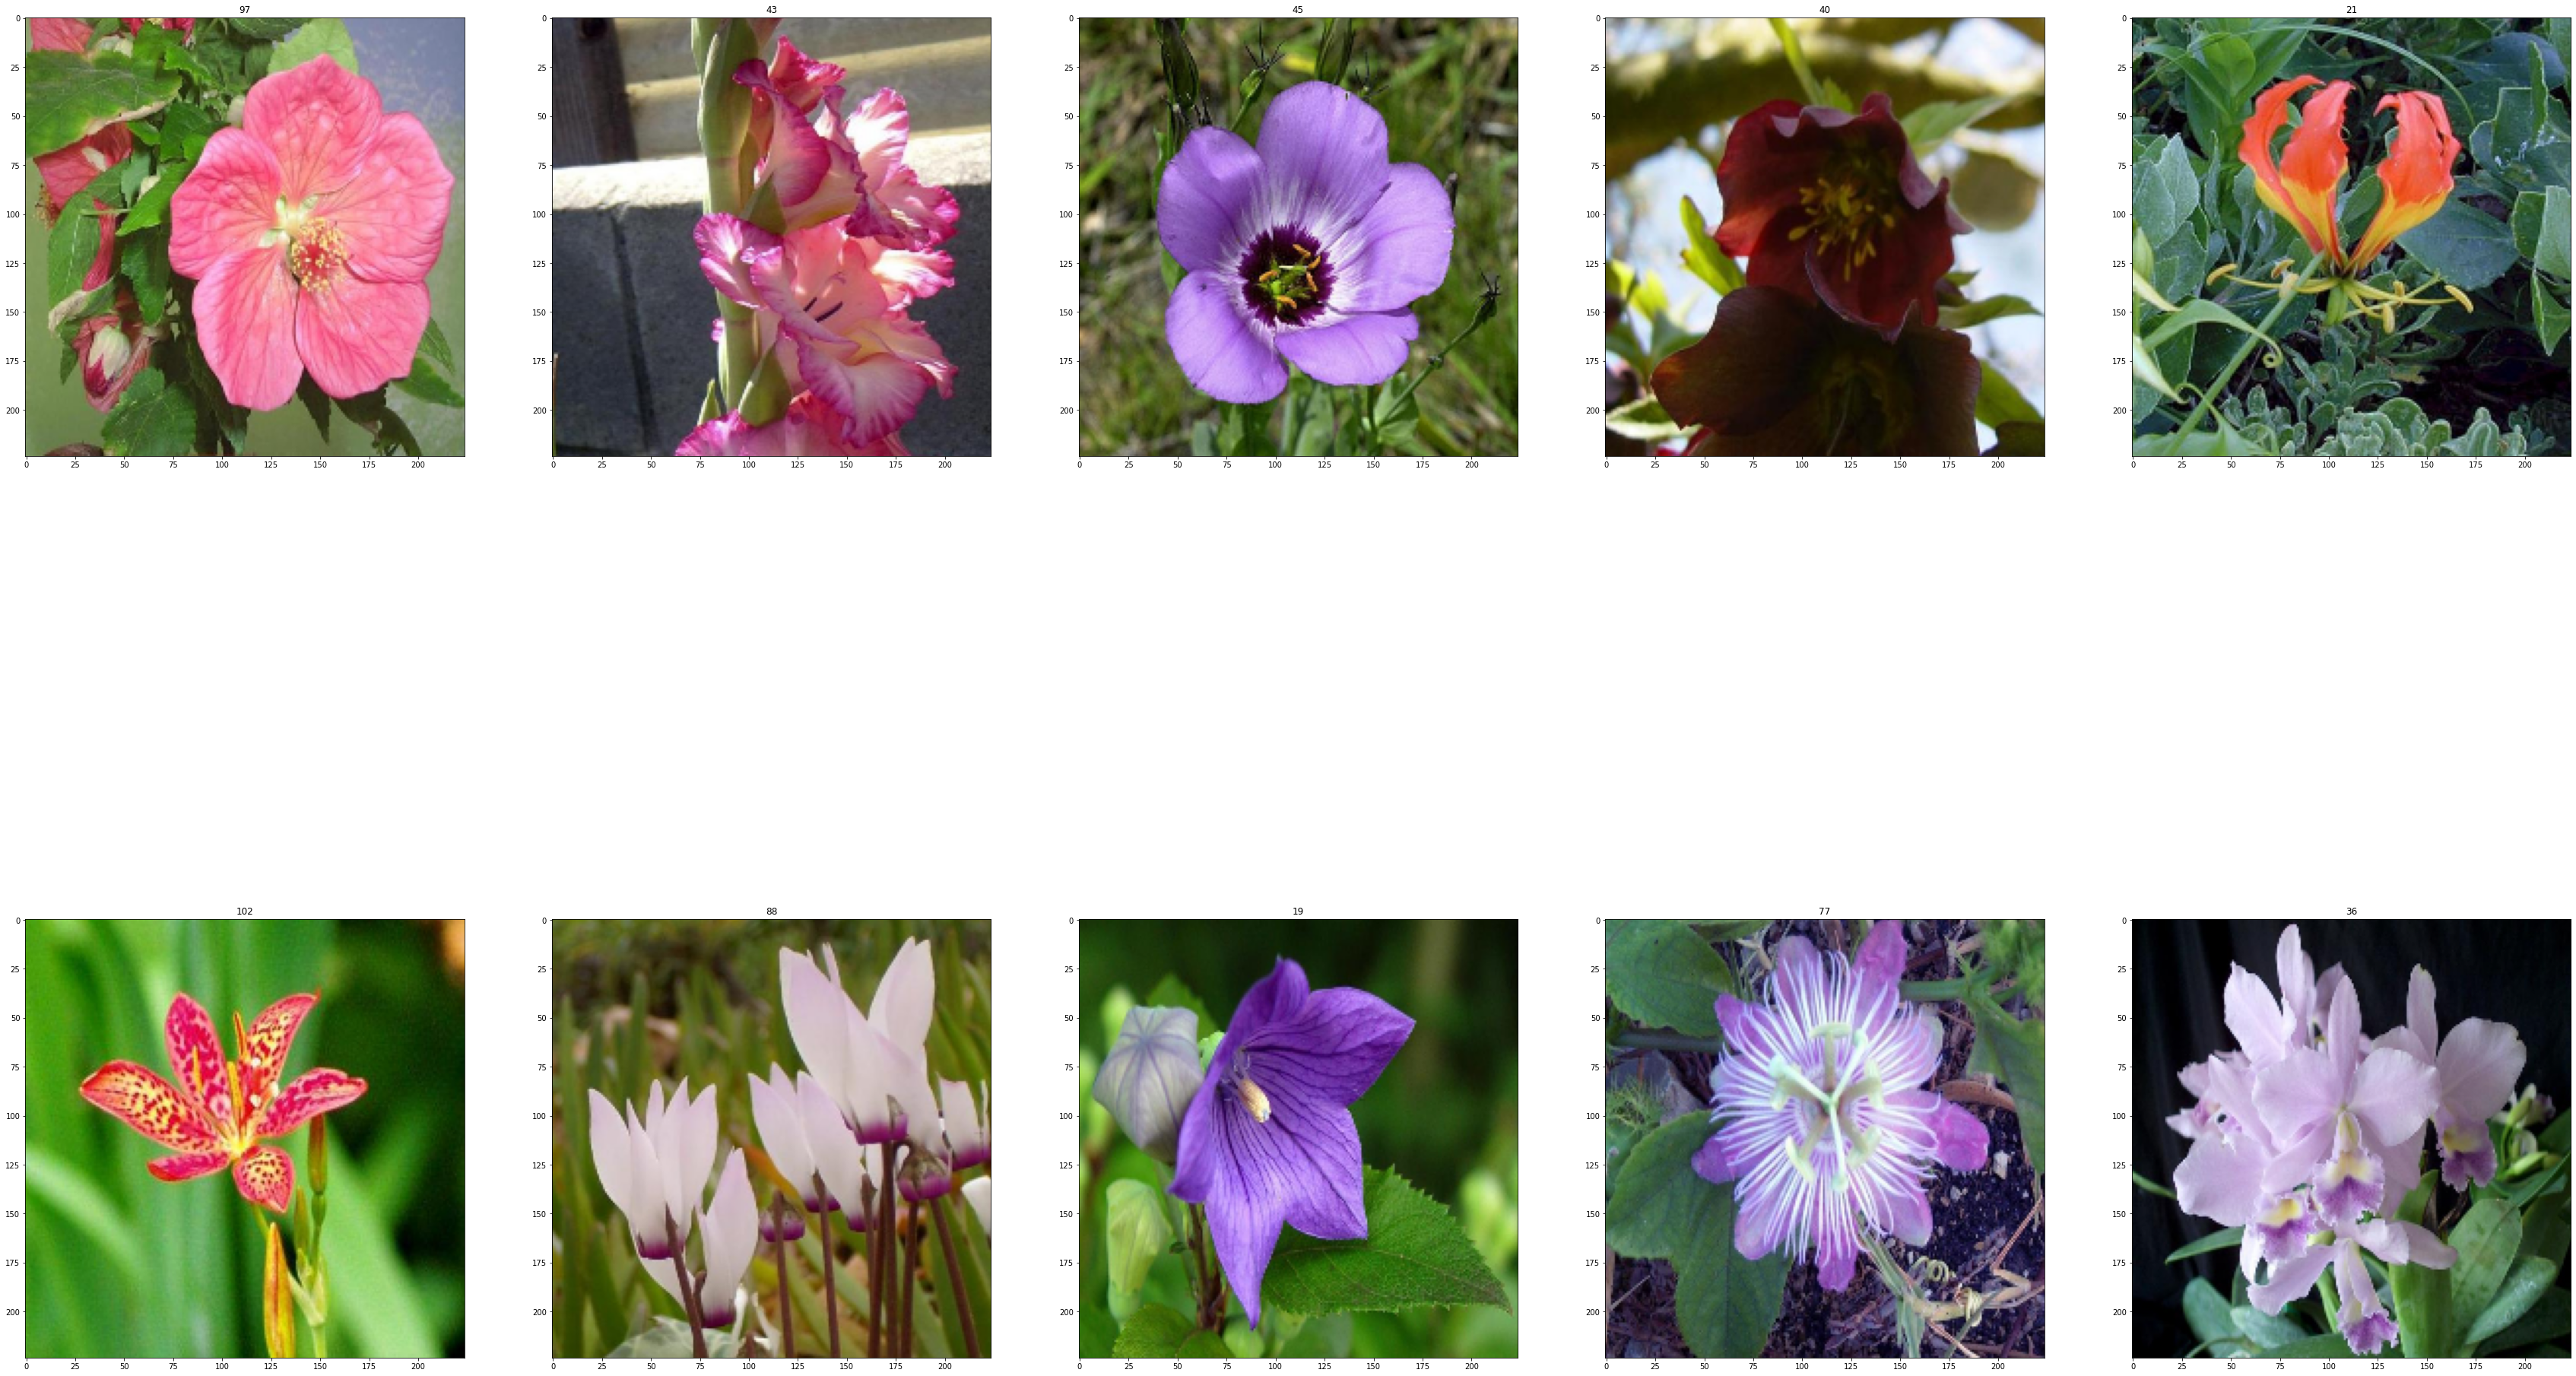

In [ ]:
imgs = load_images(X_train[:10], img_size=IMAGES_SIZE)
show_images(imgs, labels_train[:10], rows=2)

Encode labels in order to fit them to the models (using one-hot encoding)

In [38]:
encoder = MyLabelEncoder(labels)

y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

Create training tf dataset

In [39]:
train_ds = np_to_dataset(X_train, y_train, training=True, batch_size=BATCH_SIZE)

Create val tf dataset

In [40]:
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)

Create test tf dataset

In [41]:
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

# Model Training

Init a ModelTrainer supposed to be used for training all the adopted networks

In [42]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

## Pre-trained ResNet-50-v2

In [47]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMAGES_SIZE, IMAGES_SIZE, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(len(np.unique(labels)), activation='softmax'))

  return model

### Feature extraction **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 23s 57ms/step - loss: 3.6673 - accuracy: 0.1985 - val_loss: 2.8176 - val_accuracy: 0.3980
Epoch 2/30
409/409 [==============================] - 21s 51ms/step - loss: 2.1475 - accuracy: 0.5711 - val_loss: 1.9281 - val_accuracy: 0.6201
Epoch 3/30
409/409 [==============================] - 21s 52ms/step - loss: 1.4648 - accuracy: 0.7421 - val_loss: 1.4950 - val_accuracy: 0.7007
Epoch 4/30
409/409 [==============================] - 35s 87ms/step - loss: 1.1000 - accuracy: 0.8238 - val_loss: 1.2424 - val_accuracy: 0.7549
Epoch 5/30
409/409 [==============================] - 35s 86ms/step - loss: 0.8716 - accuracy: 0.8661 - val_loss: 1.0813 - val_accuracy: 0.7895
Epoch 6/30
409/409 [==============================] - 35s 87ms/step - loss: 0.7188 - accuracy: 0.8964 - val_loss: 0.9604 - val_accuracy: 0.808

In [ ]:
save_model(model, 'resnet50v2_fe')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/resnet50v2_fe/assets


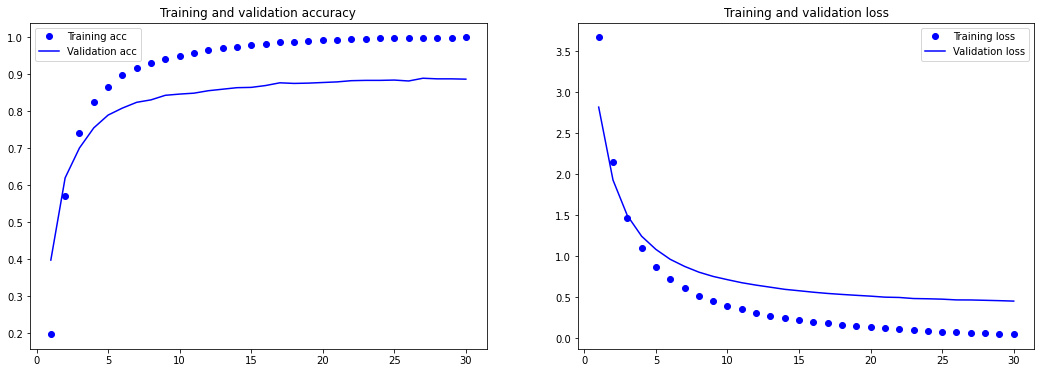

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 9.71 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.87|0.88|0.86


### Fine-tuning **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_2')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 62s 151ms/step - loss: 0.3575 - accuracy: 0.9218 - val_loss: 0.5872 - val_accuracy: 0.8660
Epoch 2/100
409/409 [==============================] - 59s 144ms/step - loss: 0.1488 - accuracy: 0.9852 - val_loss: 0.5259 - val_accuracy: 0.8775
Epoch 3/100
409/409 [==============================] - 59s 144ms/step - loss: 0.0983 - accuracy: 0.9931 - val_loss: 0.4901 - val_accuracy: 0.8857
Epoch 4/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0694 - accuracy: 0.9959 - val_loss: 0.4732 - val_accuracy: 0.8840
Epoch 5/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0530 - accuracy: 0.9982 - val_loss: 0.4519 - val_accuracy: 0.8914
Epoch 6/100
409/409 [==============================] - 77s 187ms/step - loss: 0.0403 - accuracy: 0.9988 - val_loss: 0.4415 - val_acc

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

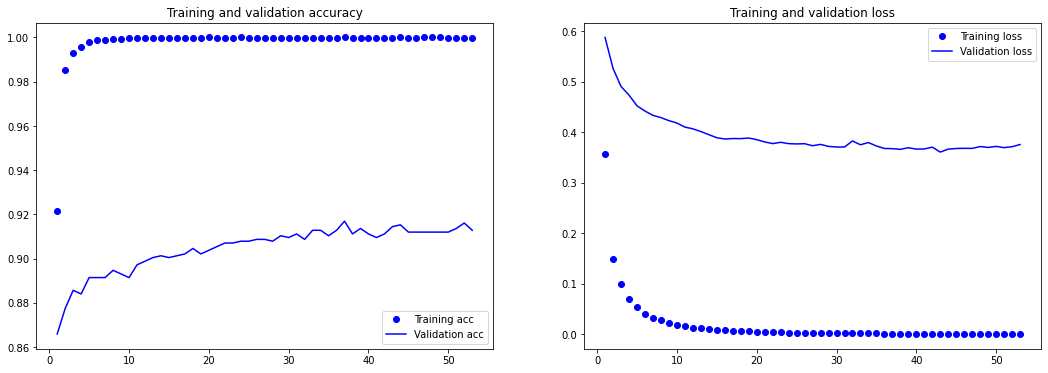

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 20.94 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.94|0.94|0.94
|Macro|0.94|0.93|0.92


### Feature extraction **with** Data Augmentation

In [57]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [48]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 5s 0us/step


In [49]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [50]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [51]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 59s 144ms/step - loss: 3.7477 - accuracy: 0.1948 - val_loss: 2.8091 - val_accuracy: 0.3890
Epoch 2/30
409/409 [==============================] - 56s 137ms/step - loss: 2.1803 - accuracy: 0.5642 - val_loss: 1.9067 - val_accuracy: 0.6225
Epoch 3/30
409/409 [==============================] - 56s 137ms/step - loss: 1.4944 - accuracy: 0.7439 - val_loss: 1.4637 - val_accuracy: 0.7146
Epoch 4/30
409/409 [==============================] - 73s 180ms/step - loss: 1.1258 - accuracy: 0.8171 - val_loss: 1.2054 - val_accuracy: 0.7689
Epoch 5/30
409/409 [==============================] - 73s 179ms/step - loss: 0.8935 - accuracy: 0.8606 - val_loss: 1.0361 - val_accuracy: 0.7977
Epoch 6/30
409/409 [==============================] - 73s 178ms/step - loss: 0.7385 - accuracy: 0.8889 - val_loss: 0.9183 - val_accuracy:

In [52]:
save_model_weights(model, 'resnet50v2_fe_aug')

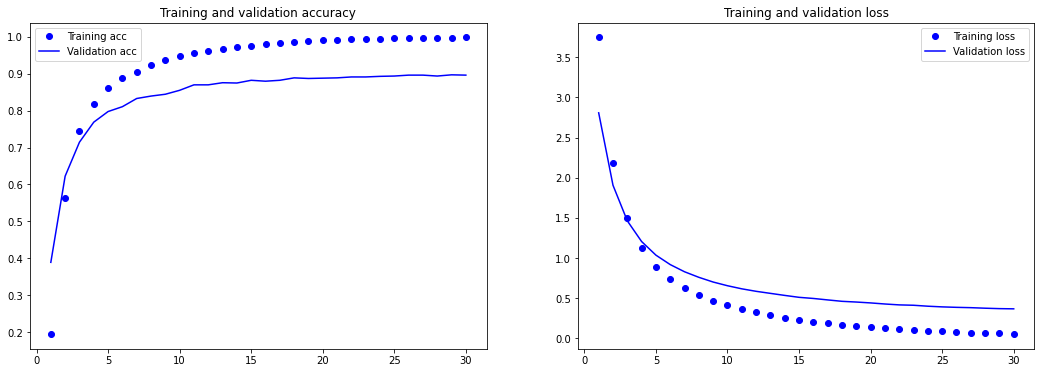

In [53]:
plot_curves(history)

In [54]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 20.66 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.90|0.90|0.90
|Macro|0.87|0.85|0.84


### Fine-tuning **with** data augmentation


In [58]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [59]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [62]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [63]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [64]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 65s 159ms/step - loss: 0.2294 - accuracy: 0.9399 - val_loss: 0.2630 - val_accuracy: 0.9202
Epoch 2/100
409/409 [==============================] - 62s 152ms/step - loss: 0.0247 - accuracy: 0.9972 - val_loss: 0.2269 - val_accuracy: 0.9276
Epoch 3/100
409/409 [==============================] - 62s 151ms/step - loss: 0.0110 - accuracy: 0.9991 - val_loss: 0.2027 - val_accuracy: 0.9326
Epoch 4/100
409/409 [==============================] - 79s 194ms/step - loss: 0.0067 - accuracy: 0.9997 - val_loss: 0.1967 - val_accuracy: 0.9375
Epoch 5/100
409/409 [==============================] - 79s 192ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.2019 - val_accuracy: 0.9359
Epoch 6/100
409/409 [==============================] - 79s 193ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.1942 - val_acc

In [65]:
save_model_weights(model, 'resnet50v2_ft_aug')

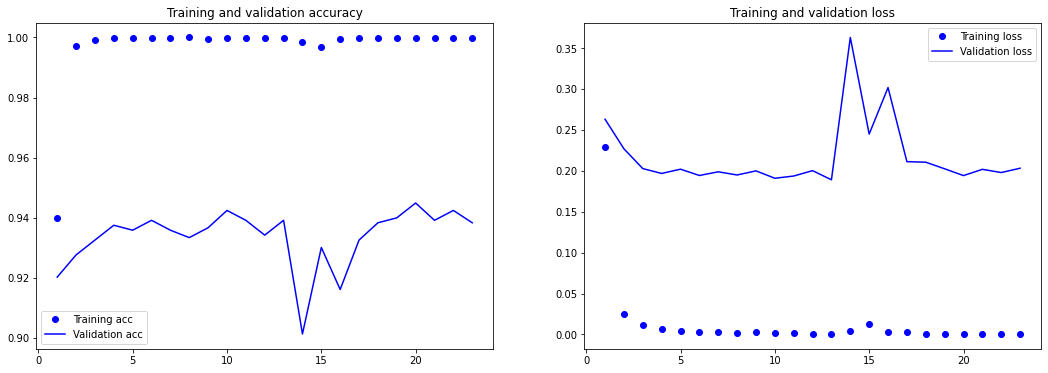

In [66]:
plot_curves(history)

In [67]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 19.35 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.93|0.93|0.93
|Macro|0.91|0.90|0.90


In [68]:
!tar czvf resnet-aug.tar.gz models/

models/
models/resnet50v2_fe_aug/
models/resnet50v2_fe_aug/checkpoint
models/resnet50v2_fe_aug/resnet50v2_fe_aug.index
models/resnet50v2_fe_aug/resnet50v2_fe_aug.data-00001-of-00002
models/resnet50v2_fe_aug/resnet50v2_fe_aug.data-00000-of-00002
models/resnet50v2_ft_aug/
models/resnet50v2_ft_aug/resnet50v2_ft_aug.index
models/resnet50v2_ft_aug/checkpoint
models/resnet50v2_ft_aug/resnet50v2_ft_aug.data-00001-of-00002
models/resnet50v2_ft_aug/resnet50v2_ft_aug.data-00000-of-00002
